---
<img src = 'logo_dh_grupo3.png'>

# <h2><left><ins>Exploración y Entranamiento de modelos basados en arboles y ensambles (bagging y boosting)</ins></left></h2>
    
   

### Introduccion.

En esta notebook se realiza una exploracion de los modelos basados en Arboles y Ensambles.

Realizamos un oversampling de los datos de entrenamiento ya que se encuentran desbalanceados.

Dado que estamos abordando un problema de clasificacion binaria supervisada con datos estructuradas se realiza un modelo base de Desicion Tree Classifier que a continuacion se toma para realizar un bagging (ensamble). Seguimos con el entrenamiento de un Ramdon Forest sin y con tuneo de hiperparametros. Asi mismo aplicamos los algoritmos de boosting basados en arboles que son considerados el estado del arte en problemas de clasificacion con datos estructurados: XGBOOST, CATBOOST y LIGHTGBM. Realizamos un voting (ensamble) con modelos ya entrenados considerados menos potentes: Regression Logistic, Knn, NaivesBayes y Random Forest
Midiendo las metricas de todos estos modelos se llega a la conclusion de que el mejor modelo a implementar es XGBOOST con oversampling para la muestra de datos otorgada.

## Importación de librerías y bases de datos

In [1]:
# Importamos las librerias relevantes
import imblearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importamos las bases de datos
data_0 = pd.read_csv("base_entrenamiento.csv")

In [3]:
# Cantidad de filas y columnas
data_0.shape

(30360, 22)

La base de datos tiene 30,360 observaciones de 21 columnas.

In [4]:
# Nombre y tipo de columnas, ademas de cantidad de filas no nulas
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30360 entries, 0 to 30359
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   housing               30360 non-null  int64  
 1   loan                  30360 non-null  int64  
 2   contact               30360 non-null  int64  
 3   campaign              30360 non-null  int64  
 4   emp.var.rate          30360 non-null  float64
 5   cons.price.idx        30360 non-null  float64
 6   cons.conf.idx         30360 non-null  float64
 7   euribor3m             30360 non-null  float64
 8   nr.employed           30360 non-null  float64
 9   y                     30360 non-null  int64  
 10  married               30360 non-null  int64  
 11  month_cat             30360 non-null  int64  
 12  age_cat_(34.0, 44.0]  30360 non-null  int64  
 13  age_cat_(44.0, 69.0]  30360 non-null  int64  
 14  job_cat_1             30360 non-null  int64  
 15  job_cat_2          

Hay 10 variables numéricas y 11 categóricas.

In [5]:
# Definimos la matriz de features, X, y el vector de la target, y
X = data_0.drop('y', axis = 1)

y = data_0['y']

In [6]:
# Separamos el dataset en Train y Test:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.30,
                                                   random_state = 42,
                                                   stratify = y)

In [7]:
# Estandarizamos las features continuas del conjunto de entrenamiento y de testeo
from sklearn.preprocessing import StandardScaler
sd = StandardScaler()

In [8]:
# Estandarizamos las variables continuas:
variables_continuas = ['campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
                       'nr.employed']
X_train[variables_continuas] = sd.fit_transform(X_train[variables_continuas])

In [9]:
# Transformamos las variables continuas en x_test con la estandarizacion aprendida en el paso anterior (con los datos de entrenamiento)
X_test[variables_continuas] = sd.transform(X_test[variables_continuas])

In [10]:
# Observamos distribucion de la variable target
print(y.value_counts(normalize = True))
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

0    0.945487
1    0.054513
Name: y, dtype: float64
0    0.945464
1    0.054536
Name: y, dtype: float64
0    0.945542
1    0.054458
Name: y, dtype: float64


Vemos que las clases de la variable target estan desbalanceadas. Procedemos a aplicar oversampling.

In [11]:
# Atendemos el problema del desbalanceo de clases con random oversampler:

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy = 'minority')
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

### Entrenamiento de modelos

# DESICION TREE

### Modelo base DesicionTree: Hiperparámetros default

In [12]:
#Importamos metricas para evaluar modelos
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, \
f1_score, roc_curve, auc, classification_report

In [13]:
#Importamos libreria time y iniciazamos para medir el tiempo de ejecucion del modelo
import time
start = time.time()

In [14]:
# Entranamiento del modelo  base Desicion Tree : hiperparametros default
from sklearn.tree import DecisionTreeClassifier

In [15]:
#Instanciamos el modelo y lo entrenamos
model_dt = DecisionTreeClassifier()

model_dt.fit(X_train_os, y_train_os)

DecisionTreeClassifier()

Veamos los hiperparámetros del modelo DecisionTreeClassifier y sus valores default

In [16]:
dt_dft_params = model_dt.get_params()
dt_dft_params

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

En https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html se puede ver una descripción de los mismos. Continuamos con las predicciones y la evaluación del modelo.

In [17]:
# Prediccion de la target usando el modelo Desicion Tree con hiperparametros defaults

y_pred_dt_dft = model_dt.predict(X_test)

y_pred_proba_dt_dft = model_dt.predict_proba(X_test)


In [18]:
# Evaluacion del modelo Desicion Tree con hiperparametros defaults

# Matriz de confusion

dt_dft_confmat = confusion_matrix(y_test, y_pred_dt_dft)

TN_dt_dft = dt_dft_confmat[0, 0] #True Negatives
FP_dt_dft = dt_dft_confmat[0, 1] #False Positives
FN_dt_dft = dt_dft_confmat[1, 0] #False Negatives
TP_dt_dft = dt_dft_confmat[1, 1] #True Positives

# Accuracy Score

dt_dft_accuracy = accuracy_score(y_test, y_pred_dt_dft)

# Error de clasificacion

dt_dft_errclf = 1 - dt_dft_accuracy

# Recall

dt_dft_recall = recall_score(y_test, y_pred_dt_dft)

# Especificidad

dt_dft_specificity = TN_dt_dft / (TN_dt_dft + FP_dt_dft)

# False Positive Rate

dt_dft_fpr = 1 - dt_dft_specificity

# Precision

dt_dft_precision = precision_score(y_test, y_pred_dt_dft)

# F1 Score

dt_dft_f1score = precision_score(y_test, y_pred_dt_dft)

# Mostramos el conjunto de medidas de evaluacion

print(f'La matriz de confusión del modelo  Desicion Tree Classifier con hiperparámetros default es: \n{dt_dft_confmat.round(2)}\n')
print(f'El accuracy score del modelo  Desicion Tree con hiperparámetros default es: {dt_dft_accuracy.round(2)}\n')
print(f'El error de clasificación del modelo Desicion Tree con hiperparámetros default es: {dt_dft_errclf.round(2)}\n')
print(f'El recall score del modelo Desicion Tree con hiperparámetros default es: {dt_dft_recall.round(2)}\n')
print(f'La especificidad del modeloDesicion Tree con hiperparámetros default es: {dt_dft_specificity.round(2)}\n')
print(f'El false positive rate del Desicion TreeTree con hiperparámetros default es: {dt_dft_fpr.round(2)}\n')
print(f'La precisión del modelo Desicion Tree con hiperparámetros default es: {dt_dft_precision.round(2)}\n')


#Resumimos la informacion en el Reporte de Clasificacion.

print(classification_report(y_test, y_pred_dt_dft))

La matriz de confusión del modelo  Desicion Tree Classifier con hiperparámetros default es: 
[[8009  603]
 [ 352  144]]

El accuracy score del modelo  Desicion Tree con hiperparámetros default es: 0.9

El error de clasificación del modelo Desicion Tree con hiperparámetros default es: 0.1

El recall score del modelo Desicion Tree con hiperparámetros default es: 0.29

La especificidad del modeloDesicion Tree con hiperparámetros default es: 0.93

El false positive rate del Desicion TreeTree con hiperparámetros default es: 0.07

La precisión del modelo Desicion Tree con hiperparámetros default es: 0.19

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      8612
           1       0.19      0.29      0.23       496

    accuracy                           0.90      9108
   macro avg       0.58      0.61      0.59      9108
weighted avg       0.92      0.90      0.90      9108



In [19]:
#Finalizamos el tiempo de ejecucion
end = time.time()
print('Execution time is:')
print(end - start)

Execution time is:
6.5600199699401855


# BAGGING

Exploramos el BagginnClassfier de scikit-learn y algunas de sus características. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [20]:
#importamos librerias para evaluacion de modelos
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RandomizedSearchCV

In [21]:
#Iniciamos temporizador
start = time.time()

In [22]:
#Importamos el clasificador de Bagging
from sklearn.ensemble import BaggingClassifier

In [23]:
#Preparamos un GridSearch para encontrar el mejor hiperparametro 
# Utilizando el siguiente diccionario de parametros, optimizar los hiperparámetros.

param_grid = {"base_estimator__max_depth": [3,5,10],
          "base_estimator__max_features": [None, "auto"],
          "base_estimator__min_samples_leaf": [1, 3, 5],
          "base_estimator__min_samples_split": [2, 5, 7],
          'bootstrap_features': [False, True],
          'max_features': [0.5, 1.0],
          'max_samples': [0.5, 1.0],
          'n_estimators': [2, 5, 10],
}


print(param_grid)

# Indicamos 10 folds para luego hacer cross validation

folds=StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Hacemos distintas GridSearchCV cada una con un Scoring diferente.

# F1
grid_f1_bag =  GridSearchCV(BaggingClassifier(DecisionTreeClassifier()), param_grid, n_jobs=-2, cv=folds, scoring='f1')
# Recall
grid_recall_bag =  GridSearchCV(BaggingClassifier(DecisionTreeClassifier()), param_grid, n_jobs=-2, cv=folds, scoring='recall')
# Precision
grid_precision_bag =  GridSearchCV(BaggingClassifier(DecisionTreeClassifier()), param_grid, n_jobs=-2, cv=folds, scoring='precision')


{'base_estimator__max_depth': [3, 5, 10], 'base_estimator__max_features': [None, 'auto'], 'base_estimator__min_samples_leaf': [1, 3, 5], 'base_estimator__min_samples_split': [2, 5, 7], 'bootstrap_features': [False, True], 'max_features': [0.5, 1.0], 'max_samples': [0.5, 1.0], 'n_estimators': [2, 5, 10]}


In [25]:
#Entrenamos el grid search
start = time.time()
#GScv con F1-score
grid_f1_bag.fit(X_train_os, y_train_os)
end = time.time()
print("tiempo de ejecucion:", (end-start))

KeyboardInterrupt: 

In [ ]:
#GScv cpn Recall
grid_recall_bag.fit(X_train_os, y_train_os)
#GScv con Precision
grid_precision_bag.fit(X_train_os, y_train_os)


In [ ]:
#GScv con Precision
grid_precision_bag.fit(X_train_os, y_train_os)


In [ ]:
#Imprimimos los estimadores seleccionados en cada GScv:
print("Mejores parametros para f1:", grid_f1_bag.best_params_)
print("Mejores parametros para recall:", grid_recall_bag.best_params_)
print("Mejores parametros para precision:", grid_precision_bag.best_params_)


In [36]:
#Imprimimos el mejor estimador en cada GScv:
best_grid_f1_bag = grid_f1_bag.best_estimator_
best_grid_recall_bag = grid_recall_bag.best_estimator_
best_grid_precision_bag = grid_precision_bag.best_estimator_
print("Mejores parametros para f1:", grid_f1_bag.best_estimator_)
print("Mejores parametros para recall:", grid_recall_bag.best_estimator_)
print("Mejres parametros para precision:", grid_precision_bag.best_estimator_)

Mejores parametros para f1: BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.5)
Mejores parametros para recall: BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.5)
Mejres parametros para precision: BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.5)


In [37]:
#imprimimos los mejores scores de cada GScv
print("Mejor puntaje de f1-score:", grid_f1_bag.best_score_)
print("Mejor puntaje de recall:", grid_recall_bag.best_score_)
print("Mejor puntaje de precision:", grid_precision_bag.best_score_)

Mejor puntaje de f1-score: 0.8757449624355977
Mejor puntaje de recall: 0.8652767521278625
Mejor puntaje de precision: 0.8949144962550248


In [38]:
# Prediccion de la target usando el modelo Bagging Classifier
y_pred_grid_bag_f1 = grid_f1_bag.predict(X_test)

y_pred_grid_bag_recall = grid_recall_bag.predict(X_test)

y_pred_grid_bag_precision = grid_precision_bag.predict(X_test)

In [39]:
#Reporte de Clasificacion
from sklearn.metrics import classification_report, confusion_matrix
print (f"y_pred_grid_bag_f1:\n",
       classification_report(y_test, y_pred_grid_bag_f1))
print (f"y_pred_grid_bag_recall:\n",
       classification_report(y_test, y_pred_grid_bag_recall))
print (f"y_pred_grid_bag-precision:\n",
       classification_report(y_test, y_pred_grid_bag_precision))

y_pred_grid_bag_f1:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93      8612
           1       0.25      0.67      0.36       496

    accuracy                           0.87      9108
   macro avg       0.61      0.78      0.65      9108
weighted avg       0.94      0.87      0.90      9108

y_pred_grid_bag_recall:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      8612
           1       0.25      0.67      0.37       496

    accuracy                           0.88      9108
   macro avg       0.62      0.78      0.65      9108
weighted avg       0.94      0.88      0.90      9108

y_pred_grid_bag-precision:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      8612
           1       0.26      0.68      0.38       496

    accuracy                           0.88      9108
   macro avg       0.62      0.79      0.66      9108


In [42]:
#Matriz de Confusion
confusion_f1_bag = confusion_matrix(y_test, y_pred_grid_bag_f1)
print(f"y_pred_rgrid_f1 confusion matrix: \n", confusion_f1_bag)
confusion_recall_bag = confusion_matrix(y_test, y_pred_grid_bag_recall)
print(f"y_pred_rgrid_recall confusion matrix: \n",confusion_recall_bag)
confusion_precision_bag = confusion_matrix(y_test, y_pred_grid_bag_precision)
print(f"y_pred_rgrid_precision confusion matrix: \n",confusion_precision_bag)

y_pred_rgrid_f1 confusion matrix: 
 [[7618  994]
 [ 165  331]]
y_pred_rgrid_recall confusion matrix: 
 [[7636  976]
 [ 162  334]]
y_pred_rgrid_precision confusion matrix: 
 [[7659  953]
 [ 157  339]]


In [43]:
#Finalizamos Temporizador y medimos tiempo de ejecucion.
end = time.time()
print('Execution time is:')
print(end - start)

Execution time is:
6675.575545549393


In [46]:
#Se guarda en disco el resultado del modelo
import pickle

In [ ]:
with open('bagging_f1.pkl','wb') as f:
    pickle.dump(grid_f1_bag,f)
    print('dump sucess')

In [48]:
with open('bagging_recall.pkl','wb') as f:
    pickle.dump(grid_recall_bag,f)
    print('dump sucess')

dump sucess


In [50]:
with open('bagging_precision.pkl','wb') as f:
    pickle.dump(grid_precision_bag,f)
    print('dump sucess')

dump sucess


# RANDOMFOREST

In [51]:
#Importamos libreria
from sklearn.ensemble import RandomForestClassifier

### Modelo base RandomFores: Hiperparámetros default

In [53]:
#Se inicia temporizador
start = time.time()

In [54]:
#Se instancia modelo RandomForestClassifier
model_rf =  RandomForestClassifier()
#Veamos los hiperparámetros del Random Forest y sus valores defaul
model_rf.fit(X_train_os, y_train_os)
rf_dft_params = model_rf.get_params()
rf_dft_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


En esta pagina se puede ver una descripción de los parametros.

https://scikit-earn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [57]:
# Prediccion de la target usando el Random Forest Tree con hiperparametros defaults

y_pred_rf_dft = model_rf.predict(X_test)

y_pred_proba_rf_dft = model_rf.predict_proba(X_test)



# Evaluacion del modelo Random Forest con hiperparametros defaults

# Matriz de confusion

rf_dft_confmat = confusion_matrix(y_test, y_pred_rf_dft)

TN_rf_dft = rf_dft_confmat[0, 0] #True Negatives
FP_rf_dft = rf_dft_confmat[0, 1] #False Positives
FN_rf_dft = rf_dft_confmat[1, 0] #False Negatives
TP_rf_dft = rf_dft_confmat[1, 1] #True Positives

# Accuracy Score

rf_dft_accuracy = accuracy_score(y_test, y_pred_rf_dft)

# Error de clasificacion

rf_dft_errclf = 1 - rf_dft_accuracy

# Recall

rf_dft_recall = recall_score(y_test, y_pred_rf_dft)

# Especificidad

rf_dft_specificity = TN_rf_dft / (TN_rf_dft + FP_rf_dft)

# False Positive Rate

rf_dft_fpr = 1 - rf_dft_specificity

# Precision

rf_dft_precision = precision_score(y_test, y_pred_rf_dft)

# F1 Score

rf_dft_f1score = precision_score(y_test, y_pred_rf_dft)

# Mostramos el conjunto de medidas de evaluacion

print(f'La matriz de confusión del modelo  Random Forest Classifier con hiperparámetros default es: \n{rf_dft_confmat.round(2)}\n')
print(f'El accuracy score del modelo  Random Forest con hiperparámetros default es: {rf_dft_accuracy.round(2)}\n')
print(f'El error de clasificación del modelo Random Forest con hiperparámetros default es: {rf_dft_errclf.round(2)}\n')
print(f'El recall score del modelo Random Forest con hiperparámetros default es: {rf_dft_recall.round(2)}\n')
print(f'La especificidad del modelo Random Forest con hiperparámetros default es: {rf_dft_specificity.round(2)}\n')
print(f'El false positive rate del Random Forest Tree con hiperparámetros default es: {rf_dft_fpr.round(2)}\n')
print(f'La precisión del modelo Random Forest con hiperparámetros default es: {rf_dft_precision.round(2)}\n')


#Resumimos la informacion en el Reporte de Clasificacion.

print(classification_report(y_test, y_pred_rf_dft))

La matriz de confusión del modelo  Random Forest Classifier con hiperparámetros default es: 
[[8088  524]
 [ 315  181]]

El accuracy score del modelo  Random Forest con hiperparámetros default es: 0.91

El error de clasificación del modelo Random Forest con hiperparámetros default es: 0.09

El recall score del modelo Random Forest con hiperparámetros default es: 0.36

La especificidad del modelo Random Forest con hiperparámetros default es: 0.94

El false positive rate del Random Forest Tree con hiperparámetros default es: 0.06

La precisión del modelo Random Forest con hiperparámetros default es: 0.26

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      8612
           1       0.26      0.36      0.30       496

    accuracy                           0.91      9108
   macro avg       0.61      0.65      0.63      9108
weighted avg       0.92      0.91      0.92      9108



In [58]:
#Se finaliza temporizador y se calcula tiempo de ejecucion.
end = time.time()
print('Execution time is:')
print(end - start)

Execution time is:
180.67117595672607


### Modelo Random Forest Hiperparámetros óptimos

In [59]:
start = time.time()
#Preparamos un GridSearch para encontrar el mejor hiperparametro
model_rf_gs = RandomForestClassifier()

# Utilizando el siguiente diccionario de parametros, optimizar los hiperparámetros.

param_grid = {  
    "n_estimators": [50,100,500],      # Number of boosted trees to fit.
    "max_features": ['auto', 'sqrt'],
    "max_depth": [1,2,3,4],            # Maximum tree depth for base learners.
    "criterion": ['gini', 'entropy']
}

print(param_grid)

# Indicamos 10 folds para luego hacer cross validation

folds=StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

{'n_estimators': [50, 100, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4], 'criterion': ['gini', 'entropy']}


In [60]:
# F1
grid_f1_rf =  GridSearchCV(model_rf_gs, param_grid, n_jobs=-2, cv=folds, scoring='f1')
# Recall
grid_recall_rf =  GridSearchCV(model_rf_gs, param_grid, n_jobs=-2, cv=folds, scoring='recall')
# Precision
grid_precision_rf =  GridSearchCV(model_rf_gs, param_grid, n_jobs=-2, cv=folds, scoring='precision')

In [61]:
# entrenamos el grid search
#GScv con F1-score
grid_f1_rf.fit(X_train_os, y_train_os)
#GScv cpn Recall
grid_recall_rf.fit(X_train_os, y_train_os)
#GScv con Precision
grid_precision_rf.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [50, 100, 500]},
             scoring='precision')

In [62]:
#Imprimimos los estimadores seleccionados en cada GScv:
print("Mejores parametros para f1:", grid_f1_rf.best_params_)
print("Mejores parametros para recall:", grid_recall_rf.best_params_)
print("Mejores parametros para precision:", grid_precision_rf.best_params_)


Mejores parametros para f1: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
Mejores parametros para recall: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}
Mejores parametros para precision: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}


In [63]:
#Imprimimos los estimadores seleccionados en cada GScv:
grid_f1_rf_best=grid_f1_rf.best_estimator_
grid_recall_rf_best=grid_recall_rf.best_estimator_
grid_precision_rf_best=grid_precision_rf.best_estimator_
print("Mejores parametros para f1:", grid_f1_rf.best_estimator_)
print("Mejores parametros para recall:", grid_recall_rf.best_estimator_)
print("Mejores parametros para precision:", grid_precision_rf.best_estimator_)

Mejores parametros para f1: RandomForestClassifier(max_depth=4)
Mejores parametros para recall: RandomForestClassifier(max_depth=4, max_features='sqrt', n_estimators=500)
Mejores parametros para precision: RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       n_estimators=50)


In [64]:
#imprimimos los mejores scores de cada GScv
print("Mejor puntaje de f1-score:", grid_f1_rf.best_score_)
print("Mejor puntaje de recall:", grid_recall_rf.best_score_)
print("Mejor puntaje de precision:", grid_precision_rf.best_score_)

Mejor puntaje de f1-score: 0.7917439951105107
Mejor puntaje de recall: 0.7901751323026481
Mejor puntaje de precision: 0.7939128839506076


In [65]:
# Prediccion de la target usando el modelo Random Forest Classifier Optimizado
y_pred_grid_rf_f1 = grid_f1_rf.predict(X_test)

y_pred_grid_rf_recall = grid_recall_rf.predict(X_test)

y_pred_grid_rf_precision = grid_precision_rf.predict(X_test)

In [66]:
#Reporte de Clasificacion
from sklearn.metrics import classification_report, confusion_matrix
print (f"y_pred_grid_rf_f1:\n",
       classification_report(y_test, y_pred_grid_rf_f1))
print (f"y_pred_grid_rf_recall:\n",
       classification_report(y_test, y_pred_grid_rf_recall))
print (f"y_pred_grid_rf-precision:\n",
       classification_report(y_test, y_pred_grid_rf_precision))

y_pred_grid_rf_f1:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      8612
           1       0.16      0.74      0.27       496

    accuracy                           0.78      9108
   macro avg       0.57      0.76      0.57      9108
weighted avg       0.94      0.78      0.84      9108

y_pred_grid_rf_recall:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      8612
           1       0.17      0.76      0.27       496

    accuracy                           0.78      9108
   macro avg       0.57      0.77      0.57      9108
weighted avg       0.94      0.78      0.84      9108

y_pred_grid_rf-precision:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      8612
           1       0.17      0.77      0.27       496

    accuracy                           0.78      9108
   macro avg       0.58      0.77      0.57      9108
wei

In [167]:
#Matriz de Confusion
confusion_f1_rf = confusion_matrix(y_test, y_pred_grid_rf_f1)
print(f"y_pred_grid_f1 confusion matrix: \n", confusion_f1_rf)
confusion_recall_rf = confusion_matrix(y_test, y_pred_grid_rf_recall)
print(f"y_pred_grid_recall confusion matrix: \n",confusion_recall_rf)
confusion_precision_rf = confusion_matrix(y_test, y_pred_grid_rf_precision)
print(f"y_pred_grid_precision confusion matrix: \n",confusion_precision_rf)

y_pred_grid_f1 confusion matrix: 
 [[6723 1889]
 [ 129  367]]
y_pred_grid_recall confusion matrix: 
 [[6719 1893]
 [ 117  379]]
y_pred_grid_precision confusion matrix: 
 [[6717 1895]
 [ 115  381]]


In [70]:
end = time.time()
print('Execution time is:')
print(end - start)

Execution time is:
2287.470594406128


In [71]:
#Guradamos modelos en disco
with open('rf_f1.pkl','wb') as f:
    pickle.dump(grid_f1_rf,f)
    print('dump sucess')

with open('rf_recall.pkl','wb') as f:
    pickle.dump(grid_recall_rf,f)
    print('dump sucess')

with open('rf_precision.pkl','wb') as f:
    pickle.dump(grid_precision_rf,f)
    print('dump sucess')


dump sucess
dump sucess
dump sucess


### Random Forest - Importancia de las features

In [74]:
important_features = list(zip(X_train_os.columns,model_rf.feature_importances_))
sorted_features = sorted(important_features, key=lambda x: x[1])

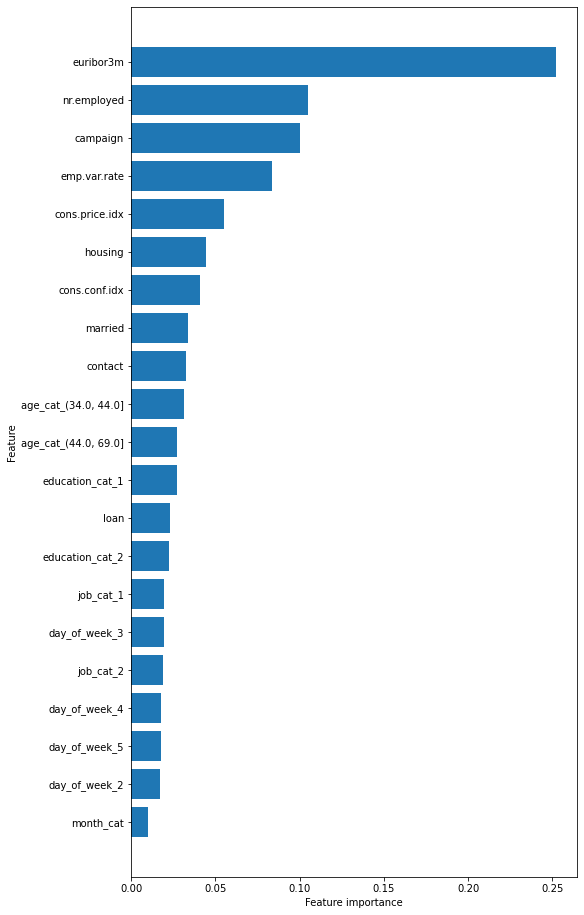

In [75]:
importance = []
feature_names = []
plt.figure(figsize=(8, 16))
n_features = X_train_os.shape[1]
for i in sorted_features:
    feature_names.append(i[0])
    importance.append(i[1])
    
plt.barh(range(n_features), importance)
plt.yticks(np.arange(n_features), feature_names)
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()


# XGBOOST

In [76]:
#Inicializamos temporizador
import time
start = time.time()

In [77]:
#importamos xgboost
from xgboost.sklearn import XGBClassifier

### Modelo base XGBOOST: Hiperparámetros default

In [79]:
#Renombramos columnas por nombre invalida para este algoritmo
X_train_os = X_train_os.rename(columns={'age_cat_(34.0, 44.0]':'age_cat_1',
                                        'age_cat_(44.0, 69.0]':'age_cat_2'})

In [81]:
model_xgb = XGBClassifier(n_jobs=-1, use_label_encoder=False)
#Veamos los hiperparámetros del XGBOOST y sus valores defaul
model_xgb.fit(X_train_os, y_train_os)
xgb_dft_params = model_xgb.get_params()
xgb_dft_params

[20:12:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

En https://xgboost.readthedocs.io/en/latest/index.html se puede ver la descripcion de los modelo XGBOOST

In [82]:
# Prediccion de la target usando el XGBOOST con hiperparametros defaults

y_pred_xgb_dft = model_xgb.predict(X_test)

y_pred_proba_xgb_dft = model_xgb.predict_proba(X_test)

In [85]:
# Evaluacion del modelo XGBOOST con hiperparametros defaults

# Matriz de confusion

xgb_dft_confmat = confusion_matrix(y_test, y_pred_xgb_dft)

TN_xgb_dft = xgb_dft_confmat[0, 0] #True Negatives
FP_xgb_dft = xgb_dft_confmat[0, 1] #False Positives
FN_xgb_dft = xgb_dft_confmat[1, 0] #False Negatives
TP_xgb_dft = xgb_dft_confmat[1, 1] #True Positives

# Accuracy Score

xgb_dft_accuracy = accuracy_score(y_test, y_pred_xgb_dft)

# Error de clasificacion

xgb_dft_errclf = 1 - xgb_dft_accuracy

# Recall

xgb_dft_recall = recall_score(y_test, y_pred_xgb_dft)

# Especificidad

xgb_dft_specificity = TN_xgb_dft / (TN_xgb_dft + FP_xgb_dft)

# False Positive Rate

xgb_dft_fpr = 1 - xgb_dft_specificity

# Precision

xgb_dft_precision = precision_score(y_test, y_pred_xgb_dft)

# F1 Score

xgb_dft_f1score = precision_score(y_test, y_pred_xgb_dft)

# Mostramos el conjunto de medidas de evaluacion

print(f'La matriz de confusión del modelo  XGBOOST Classifier con hiperparámetros default es: \n{xgb_dft_confmat.round(2)}\n')
print(f'El accuracy score del modelo  XGBOOST con hiperparámetros default es: {xgb_dft_accuracy.round(2)}\n')
print(f'El error de clasificación del modelo XGBOOST con hiperparámetros default es: {xgb_dft_errclf.round(2)}\n')
print(f'El recall score del modelo XGBOOST con hiperparámetros default es: {xgb_dft_recall.round(2)}\n')
print(f'La especificidad del modelo XGBOOST con hiperparámetros default es: {xgb_dft_specificity.round(2)}\n')
print(f'El false positive rate del XGBOOST con hiperparámetros default es: {xgb_dft_fpr.round(2)}\n')
print(f'La precisión del modelo XGBOOST con hiperparámetros default es: {xgb_dft_precision.round(2)}\n')


#Resumimos la informacion en el Reporte de Clasificacion.

print(classification_report(y_test, y_pred_xgb_dft))

La matriz de confusión del modelo  XGBOOST Classifier con hiperparámetros default es: 
[[7646  966]
 [ 193  303]]

El accuracy score del modelo  XGBOOST con hiperparámetros default es: 0.87

El error de clasificación del modelo XGBOOST con hiperparámetros default es: 0.13

El recall score del modelo XGBOOST con hiperparámetros default es: 0.61

La especificidad del modelo XGBOOST con hiperparámetros default es: 0.89

El false positive rate del XGBOOST con hiperparámetros default es: 0.11

La precisión del modelo XGBOOST con hiperparámetros default es: 0.24

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8612
           1       0.24      0.61      0.34       496

    accuracy                           0.87      9108
   macro avg       0.61      0.75      0.64      9108
weighted avg       0.94      0.87      0.90      9108



In [86]:
#finalizamos temporizador y medimos el tiempo de ejecucion
end = time.time()
print('Execution time is:')
print(end - start)

Execution time is:
183.2981390953064


### Modelo XGBOOST Hiperparámetros óptimos

In [87]:
# se inica temporizador
start = time.time()

In [90]:
#Preparamos un GridSearch para encontrar el mejor hiperparametro
model_xgb_gs = XGBClassifier(n_jobs=-1, use_label_encoder=False)


# Utilizando el siguiente diccionario de parametros, optimizar los hiperparámetros.

param_grid = {  
    "n_estimators": [50,100,500],      # Number of boosted trees to fit.
    "max_depth": [1,2,3,4],            # Maximum tree depth for base learners.
    "learning_rate": [0.01, 0.1],      # Boosting learning rate (xgb’s “eta”)
}
print(param_grid)

# Indicamos 10 folds para luego hacer cross validation
folds=StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

{'n_estimators': [50, 100, 500], 'max_depth': [1, 2, 3, 4], 'learning_rate': [0.01, 0.1]}


In [91]:
#Gridsearch
# F1
grid_f1_xgb =  GridSearchCV(model_xgb_gs, param_grid, n_jobs=-2, cv=folds, scoring='f1')
# Recall
grid_recall_xgb =  GridSearchCV(model_xgb_gs, param_grid, n_jobs=-2, cv=folds, scoring='recall')
# Precision
grid_precision_xgb =  GridSearchCV(model_xgb_gs, param_grid,  n_jobs=-2, cv=folds, scoring='precision')

In [92]:
# entrenamos el grid search
#GScv con F1-score
grid_f1_xgb.fit(X_train_os, y_train_os)
#GScv cpn Recall
grid_recall_xgb.fit(X_train_os, y_train_os)
#GScv con Precision
grid_precision_xgb.fit(X_train_os, y_train_os)

[20:29:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:38:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:46:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missi...raints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                 

In [93]:
#Imprimimos los estimadores seleccionados en cada GScv:
print("Mejores parametros para f1:", grid_f1_xgb.best_params_)
print("Mejores parametros para recall:", grid_recall_xgb.best_params_)
print("Mejores parametros para precision:", grid_precision_xgb.best_params_)


Mejores parametros para f1: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
Mejores parametros para recall: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}
Mejores parametros para precision: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500}


In [95]:
#Imprimimos los estimadores seleccionados en cada GScv:
grid_f1_xgb_best=grid_f1_xgb.best_estimator_
grid_recall_xgb_best_best=grid_recall_xgb.best_estimator_
grid_precision_xgb_best=grid_precision_xgb.best_estimator_

print("Mejores parametros para f1:", grid_f1_xgb.best_estimator_)
print("Mejores parametros para recall:", grid_recall_xgb.best_estimator_)
print("Mejores parametros para precision:", grid_precision_xgb.best_estimator_)

Mejores parametros para f1: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
Mejores parametros para recall: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monoto

In [97]:
#imprimimos los mejores scores de cada GScv
print("Mejor puntaje de f1-score:", grid_f1_xgb.best_score_)
print("Mejor puntaje de recall:", grid_recall_xgb.best_score_)
print("Mejor puntaje de precision:", grid_precision_xgb.best_score_)

Mejor puntaje de f1-score: 0.8525407367943281
Mejor puntaje de recall: 0.8268553945058184
Mejor puntaje de precision: 0.8799492435243526


In [98]:
# Prediccion de la target usando el modelo XGBOOST 
y_pred_grid_xgb_f1 = grid_f1_xgb.predict(X_test)
y_pred_grid_xgb_recall = grid_recall_xgb.predict(X_test)
y_pred_grid_xgb_precision = grid_precision_xgb.predict(X_test)

In [106]:
#Reporte de Clasificacion
from sklearn.metrics import classification_report, confusion_matrix
print (f"y_pred_grid_xgb_f1:\n",
       classification_report(y_test, y_pred_grid_xgb_f1))
print (f"y_pred_grid_xgb_recall:\n",
       classification_report(y_test, y_pred_grid_xgb_recall))
print (f"y_pred_grid_xgb-precision:\n",
       classification_report(y_test, y_pred_grid_xgb_precision))

y_pred_grid_xgb_f1:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93      8612
           1       0.24      0.68      0.36       496

    accuracy                           0.87      9108
   macro avg       0.61      0.78      0.64      9108
weighted avg       0.94      0.87      0.89      9108

y_pred_grid_xgb_recall:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93      8612
           1       0.24      0.68      0.36       496

    accuracy                           0.87      9108
   macro avg       0.61      0.78      0.64      9108
weighted avg       0.94      0.87      0.89      9108

y_pred_grid_xgb-precision:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93      8612
           1       0.24      0.68      0.36       496

    accuracy                           0.87      9108
   macro avg       0.61      0.78      0.64      9108


In [109]:
#Matriz de Confusion
confusion_f1_xgb = confusion_matrix(y_test, y_pred_grid_xgb_f1)
print(f"y_pred_grid_f1 confusion matrix: \n", confusion_f1_xgb)
confusion_recall_xgb = confusion_matrix(y_test, y_pred_grid_xgb_recall)
print(f"y_pred_grid_recall confusion matrix: \n",confusion_recall_xgb)
confusion_precision_xgb = confusion_matrix(y_test, y_pred_grid_xgb_precision)
print(f"y_pred_grid_precision confusion matrix: \n",confusion_precision_xgb)

y_pred_grid_f1 confusion matrix: 
 [[7561 1051]
 [ 159  337]]
y_pred_grid_recall confusion matrix: 
 [[7561 1051]
 [ 159  337]]
y_pred_grid_precision confusion matrix: 
 [[7561 1051]
 [ 159  337]]


In [110]:
#Finaliza temporizador y mide tiempo de ejecucion
end = time.time()
print('Execution time is:')
print(end - start)

Execution time is:
2744.762835741043


In [184]:
#Se guarda mejor modelo de GXBOOST en disco
with open('xgboost_f1.pkl','wb') as f:
    pickle.dump(grid_f1_xgb,f)
    print('dump sucess')

dump sucess


### XGBOOST - Importancia de las features

In [156]:
grid_f1_xgb_best.feature_importances_

array([0.01042385, 0.0108292 , 0.02035314, 0.01309848, 0.537626  ,
       0.02967554, 0.02338985, 0.01882701, 0.17848377, 0.01215204,
       0.01682375, 0.0149356 , 0.0109996 , 0.01783635, 0.01103012,
       0.01053535, 0.01251207, 0.01244761, 0.01203779, 0.01238559,
       0.01359723], dtype=float32)

<BarContainer object of 21 artists>

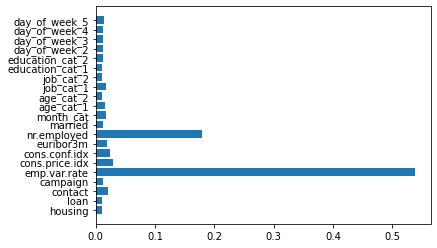

In [157]:
plt.barh(X_train_os.columns, grid_f1_xgb_best.feature_importances_)

Text(0.5, 0, 'Xgboost Feature Importance')

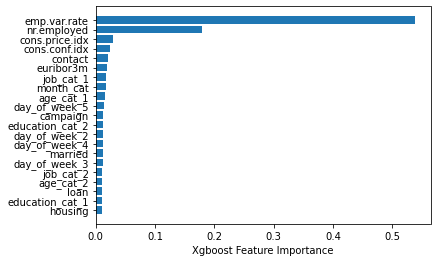

In [158]:
sorted_idx = grid_f1_xgb_best.feature_importances_.argsort()
plt.barh(X_train_os.columns[sorted_idx], grid_f1_xgb_best.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [159]:
plt.savefig('xgb_inportance.png')

<Figure size 432x288 with 0 Axes>

# VOTING  

Documentacion de Voting Classifier
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

In [169]:
#Se importa libreria de KNN
from sklearn.neighbors import KNeighborsClassifier
##knn_best = KNeighborsClassifier(n_neighbors=11)

In [176]:
#Se carga desde disco el modelo ya entrenado de KNN
with open('knn-f1.pkl','rb') as f:
    knn_best = pickle.load(f)
f.close()

In [170]:
#Se carga desde disco el modelo ya entrenado de RandomForest
with open('rf_f1.pkl','rb') as f:
    rf_best = pickle.load(f)
f.close()

In [171]:
#Se instancia un nuevo modelo con el mejor estimador previsto por el gridsearch
#rf_best = RandomForestClassifier(max_depth=4, max_features='sqrt', n_estimators=50)

In [177]:
##Se carga desde disco el modelo ya entrenado de Logistic Regression
from sklearn.linear_model import LogisticRegression
with open('lr_best.pkl','rb') as f:
    log_reg = pickle.load(f)
f.close()

In [178]:
#Se instancia un nuevo modelo NBG Gaussian
from sklearn.naive_bayes import GaussianNB
NBG = GaussianNB()

In [179]:
from sklearn.ensemble import VotingClassifier
#Se crea un diccionario de modelos
estimators=[('knn', knn_best), ('rf', rf_best), ('logreg', log_reg), ('nb', NBG)]
#Se instancia un voting imputando los modelos
ensemble = VotingClassifier(estimators, voting='hard')#poner n_jobs = -2

In [180]:
#Se fitea en train
ensemble.fit(X_train_os, y_train_os)

VotingClassifier(estimators=[('knn',
                              RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                                                 estimator=KNeighborsClassifier(),
                                                 n_iter=15, n_jobs=-2,
                                                 param_distributions={'metric': ['minkowski',
                                                                                 'manhattan'],
                                                                      'n_neighbors': [1,
                                                                                      2,
                                                                                      3,
                                                                                      4,
                                                                                      5,
                                                              

In [181]:
#Preciones del ensamble
y_pred = ensemble.predict(X_test)

In [188]:
#Reporte de Clasificacion
print (f"y_pred:\n",
       classification_report(y_test, y_pred))

y_pred:
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      8612
           1       0.16      0.73      0.26       496

    accuracy                           0.78      9108
   macro avg       0.57      0.76      0.57      9108
weighted avg       0.94      0.78      0.84      9108



In [183]:
#Matriz de Confusion
confusion_recall = confusion_matrix(y_test, y_pred)
print(f"y_pred_confusion matrix: \n",confusion_recall)

y_pred_confusion matrix: 
 [[6728 1884]
 [ 133  363]]


# CATBOOST 

Documentacion del modelo:
https://catboost.ai/docs/concepts/about.html

Con catboost los resultados sin optimizar hiperparámetros ya son excelentes. Entonces procedemos a entrenar el modelo con los datos de training con las para parametros por default.

In [111]:
start = time.time()

In [112]:
from catboost import CatBoostClassifier
model_cat = CatBoostClassifier()
model_cat.fit(X_train_os, y_train_os)

Learning rate set to 0.049874
0:	learn: 0.6675945	total: 340ms	remaining: 5m 40s
1:	learn: 0.6450384	total: 354ms	remaining: 2m 56s
2:	learn: 0.6247196	total: 370ms	remaining: 2m 2s
3:	learn: 0.6065280	total: 384ms	remaining: 1m 35s
4:	learn: 0.5897361	total: 400ms	remaining: 1m 19s
5:	learn: 0.5755267	total: 416ms	remaining: 1m 8s
6:	learn: 0.5632257	total: 431ms	remaining: 1m 1s
7:	learn: 0.5521078	total: 447ms	remaining: 55.4s
8:	learn: 0.5411411	total: 463ms	remaining: 51s
9:	learn: 0.5327733	total: 480ms	remaining: 47.5s
10:	learn: 0.5254824	total: 497ms	remaining: 44.7s
11:	learn: 0.5188027	total: 513ms	remaining: 42.2s
12:	learn: 0.5124112	total: 530ms	remaining: 40.2s
13:	learn: 0.5066983	total: 608ms	remaining: 42.9s
14:	learn: 0.5009033	total: 623ms	remaining: 40.9s
15:	learn: 0.4963374	total: 641ms	remaining: 39.4s
16:	learn: 0.4916720	total: 660ms	remaining: 38.2s
17:	learn: 0.4876347	total: 680ms	remaining: 37.1s
18:	learn: 0.4835230	total: 697ms	remaining: 36s
19:	learn: 

In [114]:
X_test = X_test.rename(columns={'age_cat_(34.0, 44.0]':'age_cat_1',
                                'age_cat_(44.0, 69.0]':'age_cat_2'})

In [115]:
#predicciones del modelo CATBOOST con hiperparametros defaults
y_pred_cat_dft = model_cat.predict(X_test)

In [116]:
# Evaluacion del modelo CATBOOST con hiperparametros defaults

# Matriz de confusion

cat_dft_confmat = confusion_matrix(y_test, y_pred_cat_dft)

TN_cat_dft = cat_dft_confmat[0, 0] #True Negatives
FP_cat_dft = cat_dft_confmat[0, 1] #False Positives
FN_cat_dft = cat_dft_confmat[1, 0] #False Negatives
TP_cat_dft = cat_dft_confmat[1, 1] #True Positives

# Accuracy Score

cat_dft_accuracy = accuracy_score(y_test, y_pred_cat_dft)

# Error de clasificacion

cat_dft_errclf = 1 - cat_dft_accuracy

# Recall

cat_dft_recall = recall_score(y_test, y_pred_cat_dft)

# Especificidad

cat_dft_specificity = TN_cat_dft / (TN_cat_dft + FP_cat_dft)

# False Positive Rate

cat_dft_fpr = 1 - cat_dft_specificity

# Precision

cat_dft_precision = precision_score(y_test, y_pred_cat_dft)

# F1 Score

cat_dft_f1score = precision_score(y_test, y_pred_cat_dft)

# Mostramos el conjunto de medidas de evaluacion

print(f'La matriz de confusión del modelo  CATBOOST Classifier con hiperparámetros default es: \n{cat_dft_confmat.round(2)}\n')
print(f'El accuracy score del modelo  CATBOOST con hiperparámetros default es: {cat_dft_accuracy.round(2)}\n')
print(f'El error de clasificación del modelo CATBOOST con hiperparámetros default es: {cat_dft_errclf.round(2)}\n')
print(f'El recall score del modelo CATBOOST con hiperparámetros default es: {cat_dft_recall.round(2)}\n')
print(f'La especificidad del modelo CATBOOST con hiperparámetros default es: {cat_dft_specificity.round(2)}\n')
print(f'El false positive rate del CATBOOST con hiperparámetros default es: {cat_dft_fpr.round(2)}\n')
print(f'La precisión del modelo CATBOOST con hiperparámetros default es: {cat_dft_precision.round(2)}\n')


#Resumimos la informacion en el Reporte de Clasificacion.

print(classification_report(y_test, y_pred_cat_dft))

La matriz de confusión del modelo  CATBOOST Classifier con hiperparámetros default es: 
[[7626  986]
 [ 173  323]]

El accuracy score del modelo  CATBOOST con hiperparámetros default es: 0.87

El error de clasificación del modelo CATBOOST con hiperparámetros default es: 0.13

El recall score del modelo CATBOOST con hiperparámetros default es: 0.65

La especificidad del modelo CATBOOST con hiperparámetros default es: 0.89

El false positive rate del CATBOOST con hiperparámetros default es: 0.11

La precisión del modelo CATBOOST con hiperparámetros default es: 0.25

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8612
           1       0.25      0.65      0.36       496

    accuracy                           0.87      9108
   macro avg       0.61      0.77      0.64      9108
weighted avg       0.94      0.87      0.90      9108



In [117]:
#finalizamos temporizador y medimos tiempo de ejecucion
end = time.time()
print('Execution time is:')
print(end - start)

Execution time is:
574.3147842884064


# LightGBM

In [118]:
#Inicializamos temporizador para medir ejecucion del modelo
start = time.time()

In [119]:
#Se importa libreria
import lightgbm as lgb

### Modelo base LightGBM: Hiperparámetros default

In [122]:
#Instanciamos el modelo LIGHTGBM 
model_lgbm= lgb.LGBMClassifier()
#Veamos los hiperparámetros del LightGBM y sus valores defaul
model_lgbm.fit(X_train_os, y_train_os)
lgbm_dft_params = model_lgbm.get_params()
lgbm_dft_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Documentacion del modelo
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier

La lista completa de hiperparámetros se puede consultar aquí https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst

In [123]:
# Prediccion de la target usando el LightGBM con hiperparametros defaults

y_pred_lgbm_dft = model_lgbm.predict(X_test)
y_pred_proba_lgbm_dft = model_lgbm.predict_proba(X_test)

In [124]:
#Evaluacion del modelo
# Matriz de confusion

lgbm_dft_confmat = confusion_matrix(y_test, y_pred_lgbm_dft)

TN_lgbm_dft = lgbm_dft_confmat[0, 0] #True Negatives
FP_lgbm_dft = lgbm_dft_confmat[0, 1] #False Positives
FN_lgbm_dft = lgbm_dft_confmat[1, 0] #False Negatives
TP_lgbm_dft = lgbm_dft_confmat[1, 1] #True Positives

# Accuracy Score

lgbm_dft_accuracy = accuracy_score(y_test, y_pred_lgbm_dft)

# Error de clasificacion

lgbm_dft_errclf = 1 - lgbm_dft_accuracy

# Recall

lgbm_dft_recall = recall_score(y_test, y_pred_lgbm_dft)

# Especificidad

lgbm_dft_specificity = TN_lgbm_dft / (TN_lgbm_dft + FP_lgbm_dft)

# False Positive Rate

lgbm_dft_fpr = 1 - lgbm_dft_specificity

# Precision

lgbm_dft_precision = precision_score(y_test, y_pred_lgbm_dft)

# F1 Score

lgbm_dft_f1score = precision_score(y_test, y_pred_lgbm_dft)

# Mostramos el conjunto de medidas de evaluacion

print(f'La matriz de confusión del modelo LightGBM Classifier con hiperparámetros default es: \n{lgbm_dft_confmat.round(2)}\n')
print(f'El accuracy score del modelo  LightGBM con hiperparámetros default es: {lgbm_dft_accuracy.round(2)}\n')
print(f'El error de clasificación del modelo LightGBM con hiperparámetros default es: {lgbm_dft_errclf.round(2)}\n')
print(f'El recall score del modelo LightGBM con hiperparámetros default es: {lgbm_dft_recall.round(2)}\n')
print(f'La especificidad del modelo LightGBM con hiperparámetros default es: {lgbm_dft_specificity.round(2)}\n')
print(f'El false positive rate del LightGBM con hiperparámetros default es: {lgbm_dft_fpr.round(2)}\n')
print(f'La precisión del modelo LightGBM con hiperparámetros default es: {lgbm_dft_precision.round(2)}\n')


#Resumimos la informacion en el Reporte de Clasificacion.

print(classification_report(y_test, y_pred_lgbm_dft))

La matriz de confusión del modelo LightGBM Classifier con hiperparámetros default es: 
[[7625  987]
 [ 143  353]]

El accuracy score del modelo  LightGBM con hiperparámetros default es: 0.88

El error de clasificación del modelo LightGBM con hiperparámetros default es: 0.12

El recall score del modelo LightGBM con hiperparámetros default es: 0.71

La especificidad del modelo LightGBM con hiperparámetros default es: 0.89

El false positive rate del LightGBM con hiperparámetros default es: 0.11

La precisión del modelo LightGBM con hiperparámetros default es: 0.26

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8612
           1       0.26      0.71      0.38       496

    accuracy                           0.88      9108
   macro avg       0.62      0.80      0.66      9108
weighted avg       0.94      0.88      0.90      9108



In [125]:
#Finalizamos temporizador y medimos tiempo de ejecucion.
end = time.time()
print('Execution time is:')
print(end - start)

Execution time is:
109.67965626716614


### Modelo LightGBM Hiperparámetros óptimos

In [126]:
#Inicializamos temporizador para medir tiempo de ejecucion
start = time.time()

In [127]:
model_lgbm_gs = lgb.LGBMClassifier()

In [128]:
param_grid = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}

In [129]:
folds=StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# F1
grid_f1_lgbm =  GridSearchCV(model_lgbm_gs, param_grid, n_jobs=-2, cv=folds, scoring='f1')
# Recall
grid_recall_lgbm =  GridSearchCV(model_lgbm_gs, param_grid, n_jobs=-2, cv=folds, scoring='recall')
# Precision
grid_precision_lgbm =  GridSearchCV(model_lgbm_gs, param_grid,  n_jobs=-2, cv=folds, scoring='precision')


In [131]:
# realizamos el grid search
#GScv con F1-score
grid_f1_lgbm.fit(X_train_os, y_train_os)
#GScv cpn Recall
grid_recall_lgbm.fit(X_train_os, y_train_os)
#GScv con Precision
grid_precision_lgbm.fit(X_train_os, y_train_os)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=LGBMClassifier(), n_jobs=-2,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [-1, 5, 10, 20],
                         'min_child_samples': [5, 10, 15],
                         'num_leaves': [20, 40, 60, 80, 100],
                         'reg_alpha': [0, 0.01, 0.03]},
             scoring='precision')

In [132]:
#Imprimimos los estimadores seleccionados en cada GScv:
print("Mejores parametros para f1:", grid_f1_lgbm.best_params_)
print("Mejores parametros para recall:", grid_recall_lgbm.best_params_)
print("Mejores parametros para precision:", grid_precision_lgbm.best_params_)

Mejores parametros para f1: {'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 5, 'num_leaves': 100, 'reg_alpha': 0}
Mejores parametros para recall: {'learning_rate': 0.2, 'max_depth': 20, 'min_child_samples': 10, 'num_leaves': 100, 'reg_alpha': 0}
Mejores parametros para precision: {'learning_rate': 0.2, 'max_depth': -1, 'min_child_samples': 5, 'num_leaves': 100, 'reg_alpha': 0.03}


In [135]:
#Imprimimos los estimadores seleccionados en cada GScv:
grid_f1_lgbm_best=grid_f1_lgbm.best_estimator_
grid_recall_lgbm_best=grid_recall_lgbm.best_estimator_
grid_precision_lgbm_best=grid_precision_lgbm.best_estimator_
print("Mejores parametros para f1:", grid_f1_lgbm.best_estimator_)
print("Mejores parametros para recall:", grid_recall_lgbm.best_estimator_)
print("Mejores parametros para precision:", grid_precision_lgbm.best_estimator_)

Mejores parametros para f1: LGBMClassifier(learning_rate=0.2, min_child_samples=5, num_leaves=100,
               reg_alpha=0)
Mejores parametros para recall: LGBMClassifier(learning_rate=0.2, max_depth=20, min_child_samples=10,
               num_leaves=100, reg_alpha=0)
Mejores parametros para precision: LGBMClassifier(learning_rate=0.2, min_child_samples=5, num_leaves=100,
               reg_alpha=0.03)


In [137]:
#imprimimos los mejores scores de cada GScv
print("Mejor puntaje de f1-score:", grid_f1_lgbm.best_score_)
print("Mejor puntaje de recall:", grid_recall_lgbm.best_score_)
print("Mejor puntaje de precision:", grid_precision_lgbm.best_score_)

Mejor puntaje de f1-score: 0.9584330560015377
Mejor puntaje de recall: 0.9927335448194567
Mejor puntaje de precision: 0.9271789719727682


In [143]:
#Predicciones del Modelo LightGBM Hiperparámetros óptimos

y_pred_grid_lgbm_f1 = grid_f1_lgbm.predict(X_test)
y_pred_grid_lgbm_recall = grid_recall_lgbm.predict(X_test)
y_pred_grid_lgbm_precision = grid_precision_lgbm.predict(X_test)

In [151]:
#Reporte de Clasificacion
from sklearn.metrics import classification_report, confusion_matrix
print (f"y_pred_grid_lgbm_f1:\n",
       classification_report(y_test, y_pred_grid_lgbm_f1))
print (f"y_pred_grid_lgbm_recall:\n",
       classification_report(y_test, y_pred_grid_lgbm_recall))
print (f"y_pred_grid_lgbm-precision:\n",
       classification_report(y_test, y_pred_grid_lgbm_precision))

y_pred_grid_lgbm_f1:
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      8612
           1       0.26      0.47      0.33       496

    accuracy                           0.90      9108
   macro avg       0.61      0.69      0.64      9108
weighted avg       0.93      0.90      0.91      9108

y_pred_grid_lgbm_recall:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      8612
           1       0.24      0.50      0.33       496

    accuracy                           0.89      9108
   macro avg       0.61      0.71      0.63      9108
weighted avg       0.93      0.89      0.90      9108

y_pred_grid_lgbm-precision:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      8612
           1       0.25      0.48      0.33       496

    accuracy                           0.89      9108
   macro avg       0.61      0.70      0.63      91

In [149]:
#Matriz de Confusion
confusion_f1_lgbm = confusion_matrix(y_test, y_pred_grid_lgbm_f1)
print(f"y_pred_grid_f1 confusion matrix: \n", confusion_f1_lgbm)
confusion_recall_lgbm = confusion_matrix(y_test, y_pred_grid_lgbm_recall)
print(f"y_pred_grid_recall confusion matrix: \n",confusion_recall_lgbm)
confusion_precision_lgbm = confusion_matrix(y_test, y_pred_grid_lgbm_precision)
print(f"y_pred_grid_precision confusion matrix: \n",confusion_precision_lgbm)

y_pred_grid_f1 confusion matrix: 
 [[7940  672]
 [ 265  231]]
y_pred_grid_recall confusion matrix: 
 [[7826  786]
 [ 246  250]]
y_pred_grid_precision confusion matrix: 
 [[7879  733]
 [ 256  240]]


In [152]:
#Finalizamos ejecucion y medimos el tiempo de ejecucion.
end = time.time()
print('Execution time is:')
print(end - start)

Execution time is:
8959.916585206985


### LIGHTGBM - Importancia de las features

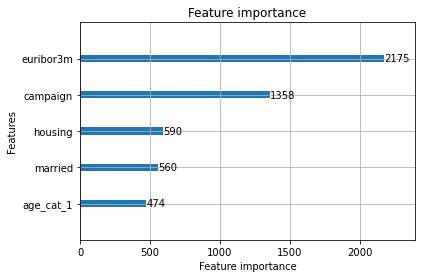

In [161]:
lgb.plot_importance(grid_f1_lgbm.best_estimator_, max_num_features=5);

## Conclusiones:

    De acuerdo a las metricas el mejor modelo eligido es XGBOOST con oversampling. 
   
    
    
   

In [185]:
print (f"y_pred_grid_xgb_f1:\n",
       classification_report(y_test, y_pred_grid_xgb_f1))

y_pred_grid_xgb_f1:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93      8612
           1       0.24      0.68      0.36       496

    accuracy                           0.87      9108
   macro avg       0.61      0.78      0.64      9108
weighted avg       0.94      0.87      0.89      9108



 •	En general, las distintas especificaciones de los algoritmos XGBOOST,LIGHTGBM y CATBOOST muestran valores similares de cada uno de los scores de evaluación.Tomando XGBOOST, Si bien obtenemos valores altos para recall (aprox.89%), no es tal el caso de precision (aprox.24%), lo cual implica también valores bajos para el f1 score (aprox.36%).
•	Esto se puede leer como que el algoritmo, al mismo tiempo que logra captar relativamente bien al cliente que potencialmente va a tomar el plazo fijo (recall), sobreestima el tamaño de la población potencial de dichos clientes (precision) a apesar de esto es el mejor algoritmo si lo comparamos con los otros modelos Si el banco toma este algoritmo, va a captar a muchos clientes correctamente, a menor costo de campaña de marketing que los otros modelos que no son los arriba mencionados.




    
    
   
    
    
    